In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
edgelist = pd.read_csv("cora/cora.cites", sep = "\t", header = None, names = ["target", "source"])
edgelist["label"]= "cites"

In [3]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv("cora/cora.content", sep = "\t", header = None, names = column_names)

In [4]:
node_data.head(5)

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [5]:
G = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(G, node_data[['subject']].to_dict('index'))

In [8]:
node_data['subject'].unique()

array(['Neural_Networks', 'Rule_Learning', 'Reinforcement_Learning',
       'Probabilistic_Methods', 'Theory', 'Genetic_Algorithms',
       'Case_Based'], dtype=object)

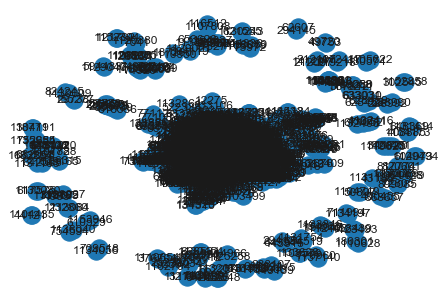

In [11]:
nx.draw(G, with_labels=True)

#### BFS

In [19]:
from queue import Queue

def min_dist_to_subject_BFS(G, s, subject):
    distance={} # initialized distance dictionary
    parents={} # initialized parents distionary
    q = Queue() # initialize empty queue to add and pop neighbors to and from 
    colors = {} # initialize colors dictionary 
    for vertex in G:
        colors[vertex] = "white"
        distance[vertex] = float("inf")
        parents[vertex]= None
    
    distance[s] = 0
    colors[s] = "gray"
    q.put(s)
    while not q.empty():
        u = q.get()
        
        if node_data.loc[u].subject == subject:
            return distance[u]
        
        for w in G.neighbors(u):
            if colors[w] == "white":
                colors[w]="gray"
                distance[w]=distance[u]+1
                parents[w]=u
                q.put(w)
                
        colors[u]="black"
                    
    return float('inf') 

In [20]:
min_dist_to_subject_BFS(G, 13195, "Reinforcement_Learning")

0

We will find an average citation distance from "Probabilistic_Methods" to "Theory"

In [21]:
distance = node_data[node_data.subject == "Probabilistic_Methods"].index.to_series().apply(lambda node_id: min_dist_to_subject_BFS(G, node_id, "Theory"))

In [22]:
distance[distance != float("inf")].mean()

3.704485488126649

**Citation distance from "Probabilistic Methods" to "Theory" is 3.7, on average**

Text(0.5, 1.0, 'Citation distance from "Probabilistic Methods" to "Theory"')

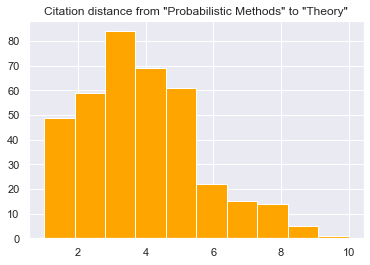

In [23]:
plt.hist(distance[distance != float("inf")], color='orange')
plt.title('Citation distance from "Probabilistic Methods" to "Theory"')

#### Bellman-Ford

In [24]:
the_most_cited_paper = sorted(G.degree, key=lambda x: x[1], reverse=True)[0]
the_most_cited_paper

(35, 168)

**Paper with the most citations is 35**

In [25]:
dist = nx.single_source_bellman_ford_path_length(G, 35)

In [26]:
pd.Series(list(dist.values())).mean()

4.1175050301810865

Text(0.5, 1.0, 'Citation distance between the most cited paper and the other papers')

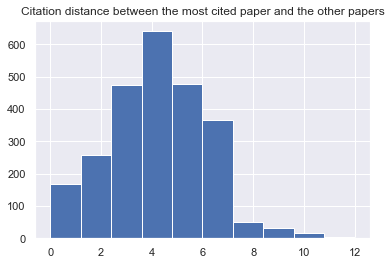

In [27]:
plt.hist(list(dist.values()))
plt.title("Citation distance between the most cited paper and the other papers")

**Average distance from the most cited paper to the rest of the papers is 4.1**

#### Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np

In [59]:
train, test = np.split(node_data, [int(0.6 * len(node_data))])

In [71]:
X_train = train.values[:, :-1].astype(int)
y_train = train.values[:, -1]

X_test = test.values[:, :-1].astype(int)
y_test = test.values[:, -1]

In [69]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [72]:
log_reg.score(X_train, y_train)

0.9926108374384236

In [73]:
log_reg.score(X_test, y_test)

0.731549815498155

**The train model accuracy is 99.3% whereas the test model accuracy is 73.2%. Nevertheless, logistic regression can quite accurately predict the subject of the paper**

#### Decision Tree

In [84]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=30)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30)

In [85]:
decision_tree.score(X_train, y_train)

0.8793103448275862

In [86]:
decision_tree.score(X_test, y_test)

0.6254612546125461

**Decision Tree performs slightly worse than logistic tree**

#### K Means

In [87]:
X = node_data.values[:, :-1].astype(int)
y = node_data.values[:, -1]

In [88]:
from sklearn.cluster import KMeans

In [92]:
kmeans = KMeans(n_clusters=len(node_data.subject.unique()))
kmeans.fit(X)

KMeans(n_clusters=7)

In [94]:
kmeans.score(X, y)

-44299.18349248992

In [98]:
from sklearn.metrics.cluster import completeness_score

In [100]:
completeness_score(y, kmeans.predict(X))

0.22974566718118944

**It is possible to observe that kmeans was not able to identify clusters that correspond to paper subjects**